In [1]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----
# modify features

## make Cabin First character feature

In [4]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

In [5]:
train_df["Cabin_Letter"].value_counts()

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

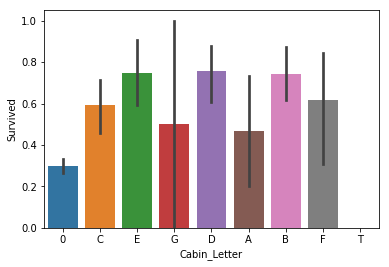

In [6]:
sns.barplot(data=train_df, x="Cabin_Letter", y="Survived")

In [7]:
test_df["Cabin_Letter"].value_counts()

0    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin_Letter, dtype: int64

### make dummy variable for Cabin_Letter

In [8]:
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(1309, 13)
(891, 21) (418, 20)


In [9]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,A/5 21171,1,0,0,0,0,0,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,PC 17599,0,0,0,1,0,0,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,STON/O2. 3101282,1,0,0,0,0,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,113803,0,0,0,1,0,0,0,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,373450,1,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,330911,1,0,0,0,0,0,0,0,0
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,363272,1,0,0,0,0,0,0,0,0
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,240276,1,0,0,0,0,0,0,0,0
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,315154,1,0,0,0,0,0,0,0,0
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,3101298,1,0,0,0,0,0,0,0,0


## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

## del Ticket, Cabin columns

In [11]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [12]:
train_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,1,0,0,0,0,0,0,0,0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,0,0,0,1,0,0,0,0,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,1,0,0,0,0,0,0,0,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,0,0,0,1,0,0,0,0,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,1,0,0,0,0,0,0,0,0


## add title

In [13]:
# add title

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Capt          1
Don           1
Sir           1
Mme           1
Ms            1
Countess      1
Lady          1
Name: Title, dtype: int64

### try one hote encoding without delete rare title

In [14]:
# try one hote encoding without delete rare title
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 20) (418, 19)
(1309, 20)
(891, 37) (418, 36)


In [15]:
test_df.head()

,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,34.5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,47.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,62.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,27.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,22.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### del rare title and map value

## drop Name, PassengerId

## map value to Sex 

In [16]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)
train_df.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## fill na value

In [17]:
train_df.isna().any()

Age                True
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
Embarked           True
Fare              False
Name              False
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

In [18]:
test_df.isna().any()

Age                True
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
Embarked          False
Fare               True
Name              False
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

### fill na of Age

In [19]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
train_df.isna().any()

Age               False
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
Embarked           True
Fare              False
Name              False
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

#### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

### add age band

In [21]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,AgeBand
0,22,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"(16.0, 32.0]"
1,38,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
2,26,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"(16.0, 32.0]"
3,35,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
4,35,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"(32.0, 48.0]"


### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [22]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Create new feature "FamilySize"

In [23]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    

train_df.head()

,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,FamilySize,IsAlone,Age*Class
0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,3
1,2,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,2
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,3
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,2
4,2,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,6


### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [24]:
# keep Parch, SibSp only. this was best amoung familly related features

train_df = train_df.drop(['FamilySize', 'IsAlone'], axis=1)
test_df = test_df.drop(['FamilySize', 'IsAlone'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Age,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age*Class
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
1,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
2,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
4,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6


## fill missing Embarked 

In [25]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)


## Converting Embarked categorical feature to numeric

## try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [26]:
# try one hote encoding for Embarked
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

train_df.head()

(891, 38) (418, 37)
(1309, 38)
(891, 40) (418, 39)


,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## fill na of test data Fare

In [27]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,6,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,3,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## make Fareband feature

In [28]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]
    
train_df.head(10)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,3,3,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

## drop Name, PassengerId

In [29]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## final check data

In [30]:
train_df.head()

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [31]:
test_df.head()

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,6,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,3,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


----

# model and estimate

In [32]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

# make train, test data set from train.csv

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 37) (295, 37)


## SVC

Mean cross-validated score of the best_estimator:  0.815436241611
best parameters: {'C': 10, 'gamma': 0.01}
test:  0.847457627119


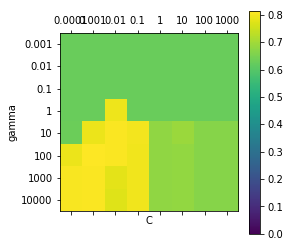

In [34]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=3)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

----

# random forest result for compare

In [35]:
X_train_df.head()

,Age,Age*Class,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [36]:
pipe = make_pipeline(RandomForestClassifier(max_depth=None, 
                                            max_features=None,
                                            min_samples_leaf=4, 
                                            min_samples_split=2, 
                                            n_estimators=10))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score: ", scores.mean())

test:  0.827118644068
mean of cross val score:  0.813692480359


In [37]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
14,Sex,0.246757
29,Title_Mr,0.226134
13,Pclass,0.182743
15,SibSp,0.068453
11,Fare,0.053840
12,Parch,0.042622
34,Embarked_C,0.028627
1,Age*Class,0.023804
2,Cabin_Letter_0,0.018959
36,Embarked_S,0.018888


## GradientBoostingClassifier

In [38]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.01, 
                                            max_depth=3,
                                            n_estimators=200))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score: ", scores.mean())

test:  0.837288135593
mean of cross val score:  0.824915824916


In [39]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
14,Sex,0.273604
29,Title_Mr,0.196305
13,Pclass,0.154097
15,SibSp,0.089625
7,Cabin_Letter_E,0.031023
2,Cabin_Letter_0,0.030556
34,Embarked_C,0.029103
11,Fare,0.028398
25,Title_Master,0.027834
36,Embarked_S,0.027621
